# **Homework1 Exploration & Exploitation**  
Napat Aeimwiratchai 65340500020

## Import library

In [137]:
import numpy as np
import matplotlib.pyplot as plt

## Bandit class

    a. A constructor which initializes an agent with learnable parameters, and steps for each action.  
    b. A function which returns a reward signal.

In [ ]:
class Bandit:
    def __init__(self, n_bandits, rewards, sd):
        self.n_bandits = n_bandits          # Number of bandit
        self.rewards = rewards              # Rewards per bandit
        self.sd = sd                        # Standard Diviation (Reward distribution)
    
    def pull(self, action):
        return np.random.normal(loc=self.rewards[action], scale=self.sd)    # Random reward from distribution

## Agent class

    a. A constructor which initializes an agent with learnable parameters, and steps for each action.
    b. An update function that updates the agent’s learnable parameters and steps.

In [139]:
class Agent:
    def __init__(self, n_bandits, epsilon=0.1, ucb_c=2):
        self.n_bandits = n_bandits
        self.epsilon = epsilon
        self.ucb_c = ucb_c
        self.q_estimated = np.zeros(n_bandits)  # Estimated reward values
        self.action_counts = np.zeros(n_bandits)  # Action selection counts
        self.total_steps = 0
    
    def select_action_epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0,self.n_bandits)  # Explore
        else:
            return np.argmax(self.q_estimated)  # Exploit
    
    def select_action_ucb(self):
        self.total_steps += 1
        if 0 in self.action_counts:
            return np.argmin(self.action_counts)  # Ensure each action is selected at least once
        ucb_values = self.q_estimated + self.ucb_c * np.sqrt(np.log(self.total_steps) / (self.action_counts + 1e-5))
        return np.argmax(ucb_values)
    
    def update(self, action, reward):
        # self.action_counts[action] += 1
        # alpha = 1.0 / self.action_counts[action]  # Incremental update rule
        # self.q_estimated[action] += alpha * (reward - self.q_estimated[action])
        
        
        self.action_counts[action] += 1
        n = self.action_counts[action]
        value = self.q_estimated[action]
        self.q_estimated[action] = ((n - 1) / n) * value + (1 / n) * reward

## Simulation Script

In [140]:
def run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=False, ucb_c=0.1):
    bandit = Bandit(n_bandits, rewards, sd)
    agent = Agent(n_bandits, epsilon, ucb_c)
    rewards_log = np.zeros((n_bandits, time_steps))
    
    for t in range(time_steps):
        if ucb:
            action = agent.select_action_ucb()
        else:
            action = agent.select_action_epsilon_greedy()
        # print((agent.q_estimated))
        reward = bandit.pull(action)
        agent.update(action, reward)
        rewards_log[action, t] = reward
    
    return rewards_log

In [ ]:
def plot_results(n_bandits, rewards, sd, time_steps, epsilon, ucb_c):
    
    rewards_epsilon_greedy = run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=False, ucb_c=ucb_c)
    rewards_ucb = run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=True, ucb_c=ucb_c)

    fig, axes = plt.subplots(3, 2, figsize=(16, 14))  

    last_10_percent = int(time_steps * 0.1)  
    time_full = np.arange(time_steps) + 1  

    total_rewards_epsilon = np.sum(rewards_epsilon_greedy, axis=1)  # Sum of rewards per bandit (Epsilon-Greedy)
    total_rewards_ucb = np.sum(rewards_ucb, axis=1)  # Sum of rewards per bandit (UCB)

    best_bandit_epsilon = np.argmax(total_rewards_epsilon)  # Best bandit for Epsilon-Greedy
    best_bandit_ucb = np.argmax(total_rewards_ucb)  # Best bandit for UCB

    print(f"- Best Bandit (Epsilon-Greedy): Bandit {best_bandit_epsilon} with Total Reward = {total_rewards_epsilon[best_bandit_epsilon]:.2f}")
    print(f"- Best Bandit (UCB): Bandit {best_bandit_ucb} with Total Reward = {total_rewards_ucb[best_bandit_ucb]:.2f}")
    
    # --- Full Range Plots ---
    for i in range(n_bandits):
        axes[0, 0].plot(time_full, np.cumsum(rewards_epsilon_greedy[i, :]) / time_full, label=f"Bandit {i}")
    axes[0, 0].set_xscale("log")
    axes[0, 0].set_title(f"Epsilon-Greedy Strategy")
    axes[0, 0].set_xlabel("Time Steps (Log Scale)")
    axes[0, 0].set_ylabel("Average Reward")
    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[0, 0].grid(True, which="both", linestyle="--", linewidth=0.5)

    for i in range(n_bandits):
        axes[0, 1].plot(time_full, np.cumsum(rewards_ucb[i, :]) / time_full, label=f"Bandit {i}")
    axes[0, 1].set_xscale("log")
    axes[0, 1].set_title(f"Upper Confidence Bound (UCB) Strategy")
    axes[0, 1].set_xlabel("Time Steps (Log Scale)")
    axes[0, 1].set_ylabel("Average Reward")
    axes[0, 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[0, 1].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Zoomed-In (Last 10%) 
    for i in range(n_bandits):
        axes[1, 0].plot(time_full[-last_10_percent:], 
                        np.cumsum(rewards_epsilon_greedy[i, -last_10_percent:]) / time_full[-last_10_percent:], 
                        label=f"Bandit {i}")
    axes[1, 0].set_xscale("linear")  # No log scale for zoomed-in view
    axes[1, 0].set_title(f"Epsilon-Greedy Strategy (Last 10% of Timesteps)")
    axes[1, 0].set_xlabel("Time Steps (Actual Scale from Full Range)")
    axes[1, 0].set_ylabel("Average Reward")
    axes[1, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1))

    axes[1, 0].grid(True, linestyle="--", linewidth=0.5)

    for i in range(n_bandits):
        axes[1, 1].plot(time_full[-last_10_percent:], 
                        np.cumsum(rewards_ucb[i, -last_10_percent:]) / time_full[-last_10_percent:], 
                        label=f"Bandit {i}")
    axes[1, 1].set_xscale("linear")  # No log scale for zoomed-in view
    axes[1, 1].set_title(f"Upper Confidence Bound (UCB) Strategy (Last 10% of Timesteps)")
    axes[1, 1].set_xlabel("Time Steps (Actual Scale from Full Range)")
    axes[1, 1].set_ylabel("Average Reward")
    axes[1, 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))

    axes[1, 1].grid(True, linestyle="--", linewidth=0.5)

    # Cumulative Rewards Per Time Step
    for i in range(n_bandits):
        axes[2, 0].plot(time_full, np.cumsum(rewards_epsilon_greedy[i, :]), alpha=1.0, label=f"Bandit {i}")
    axes[2, 0].set_xscale("log")
    axes[2, 0].set_title("Cumulative Rewards Per Time Step (Epsilon-Greedy)")
    axes[2, 0].set_xlabel("Time Steps (Log Scale)")
    axes[2, 0].set_ylabel("Cumulative Reward")
    axes[2, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[2, 0].grid(True, linestyle="--", linewidth=0.5)

    for i in range(n_bandits):
        axes[2, 1].plot(time_full, np.cumsum(rewards_ucb[i, :]), alpha=0.8, label=f"Bandit {i}")
    axes[2, 1].set_xscale("log")
    axes[2, 1].set_title("Cumulative Rewards Per Time Step (UCB)")
    axes[2, 1].set_xlabel("Time Steps (Log Scale)")
    axes[2, 1].set_ylabel("Cumulative Reward")
    axes[2, 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[2, 1].grid(True, linestyle="--", linewidth=0.5)

    plt.suptitle(f"Comparison of Epsilon-Greedy and UCB Algorithms(ε = {epsilon} ,c={ucb_c})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return rewards_epsilon_greedy, rewards_ucb


In [142]:
# Define rewards for the bandits
n_bandits = 10
rewards_each_bandit = [0.1, 0.15, 0.21, 0.25, 0.4, 0.22, 0.15, 0.3, 0.25, 0.05]
sd = 0.5
time_step = 100000
epsilon_values = [0.01, 0.3, 0.5, 1.0]
c_values = [0.01, 1, 5, 10]

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 39485.20
- Best Bandit (UCB): Bandit 4 with Total Reward = 40017.44


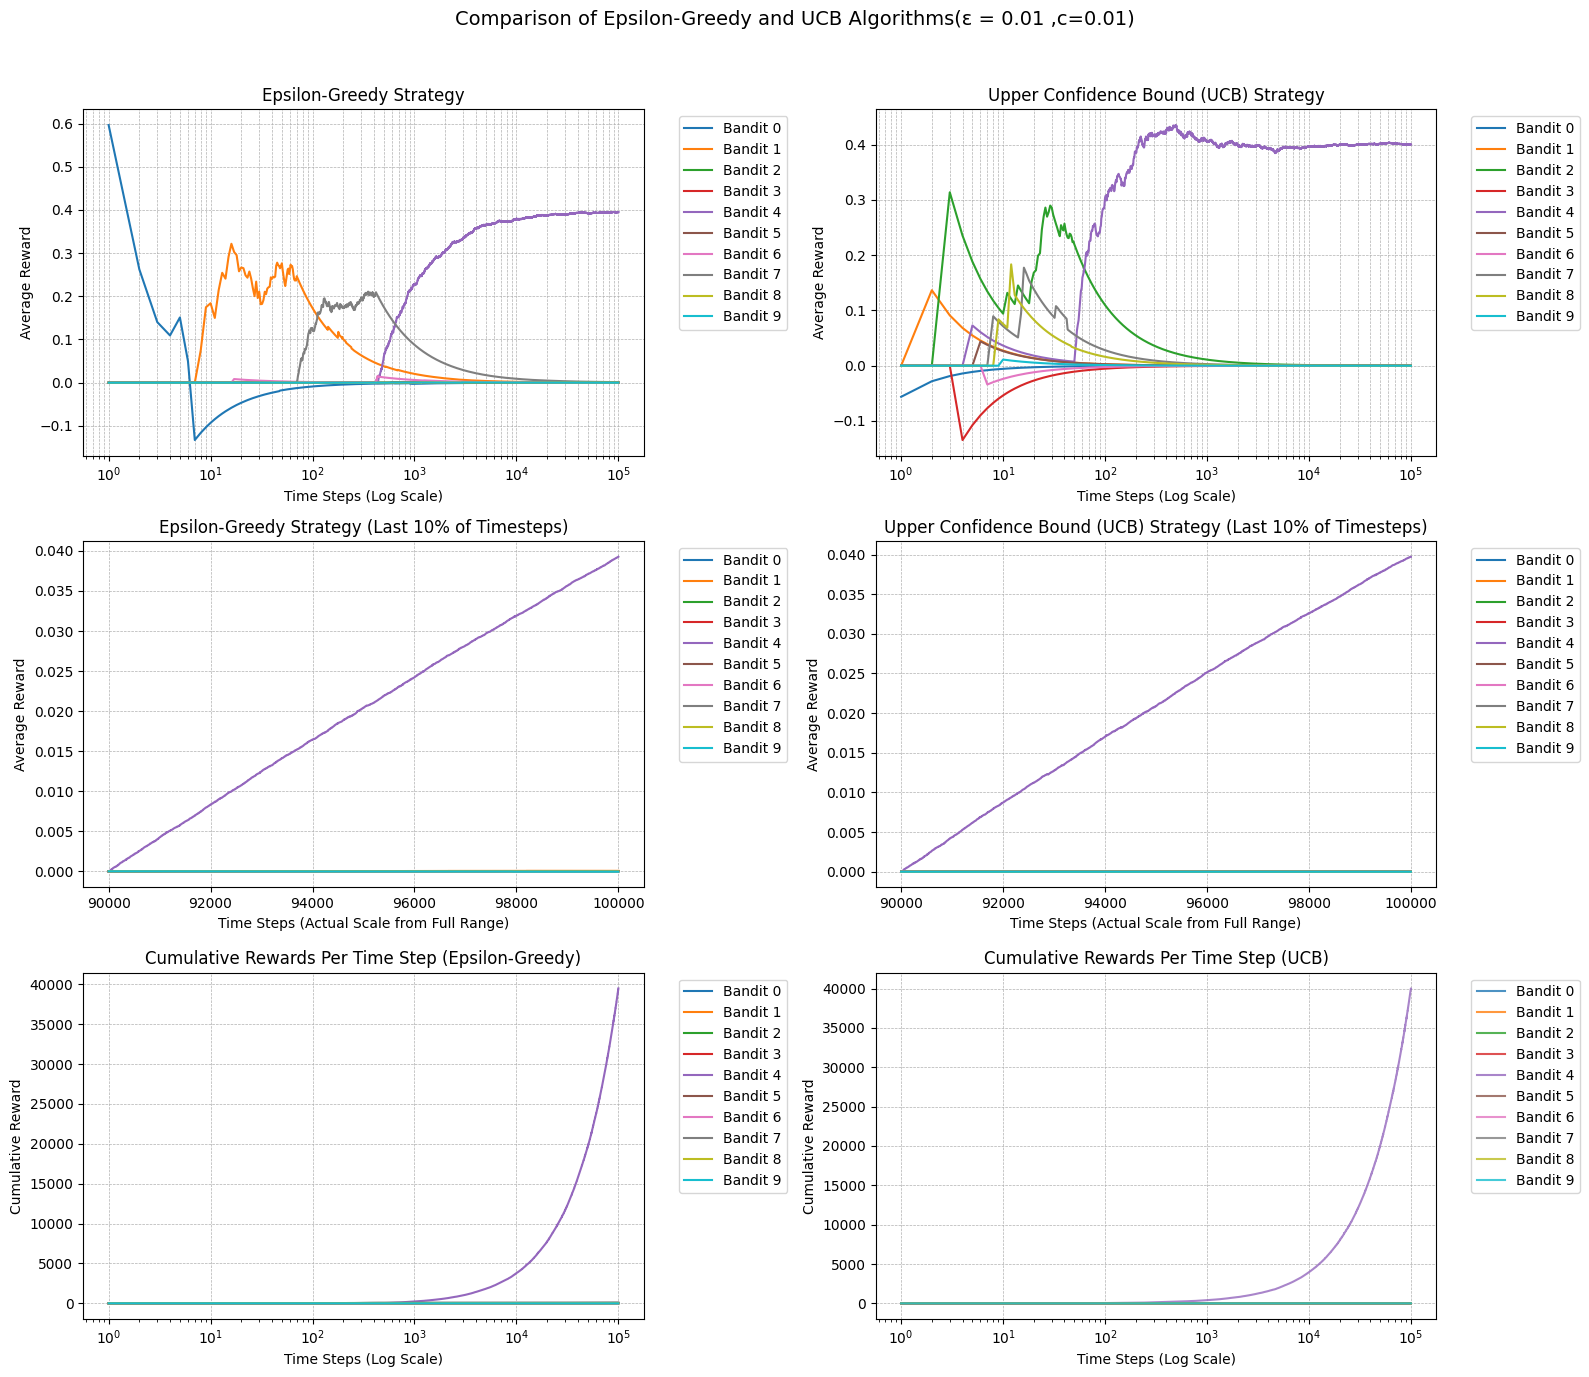

In [143]:
rew_epsilon_0, rew_ucb_0 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[0], ucb_c=c_values[0])

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 29108.40
- Best Bandit (UCB): Bandit 4 with Total Reward = 38830.08


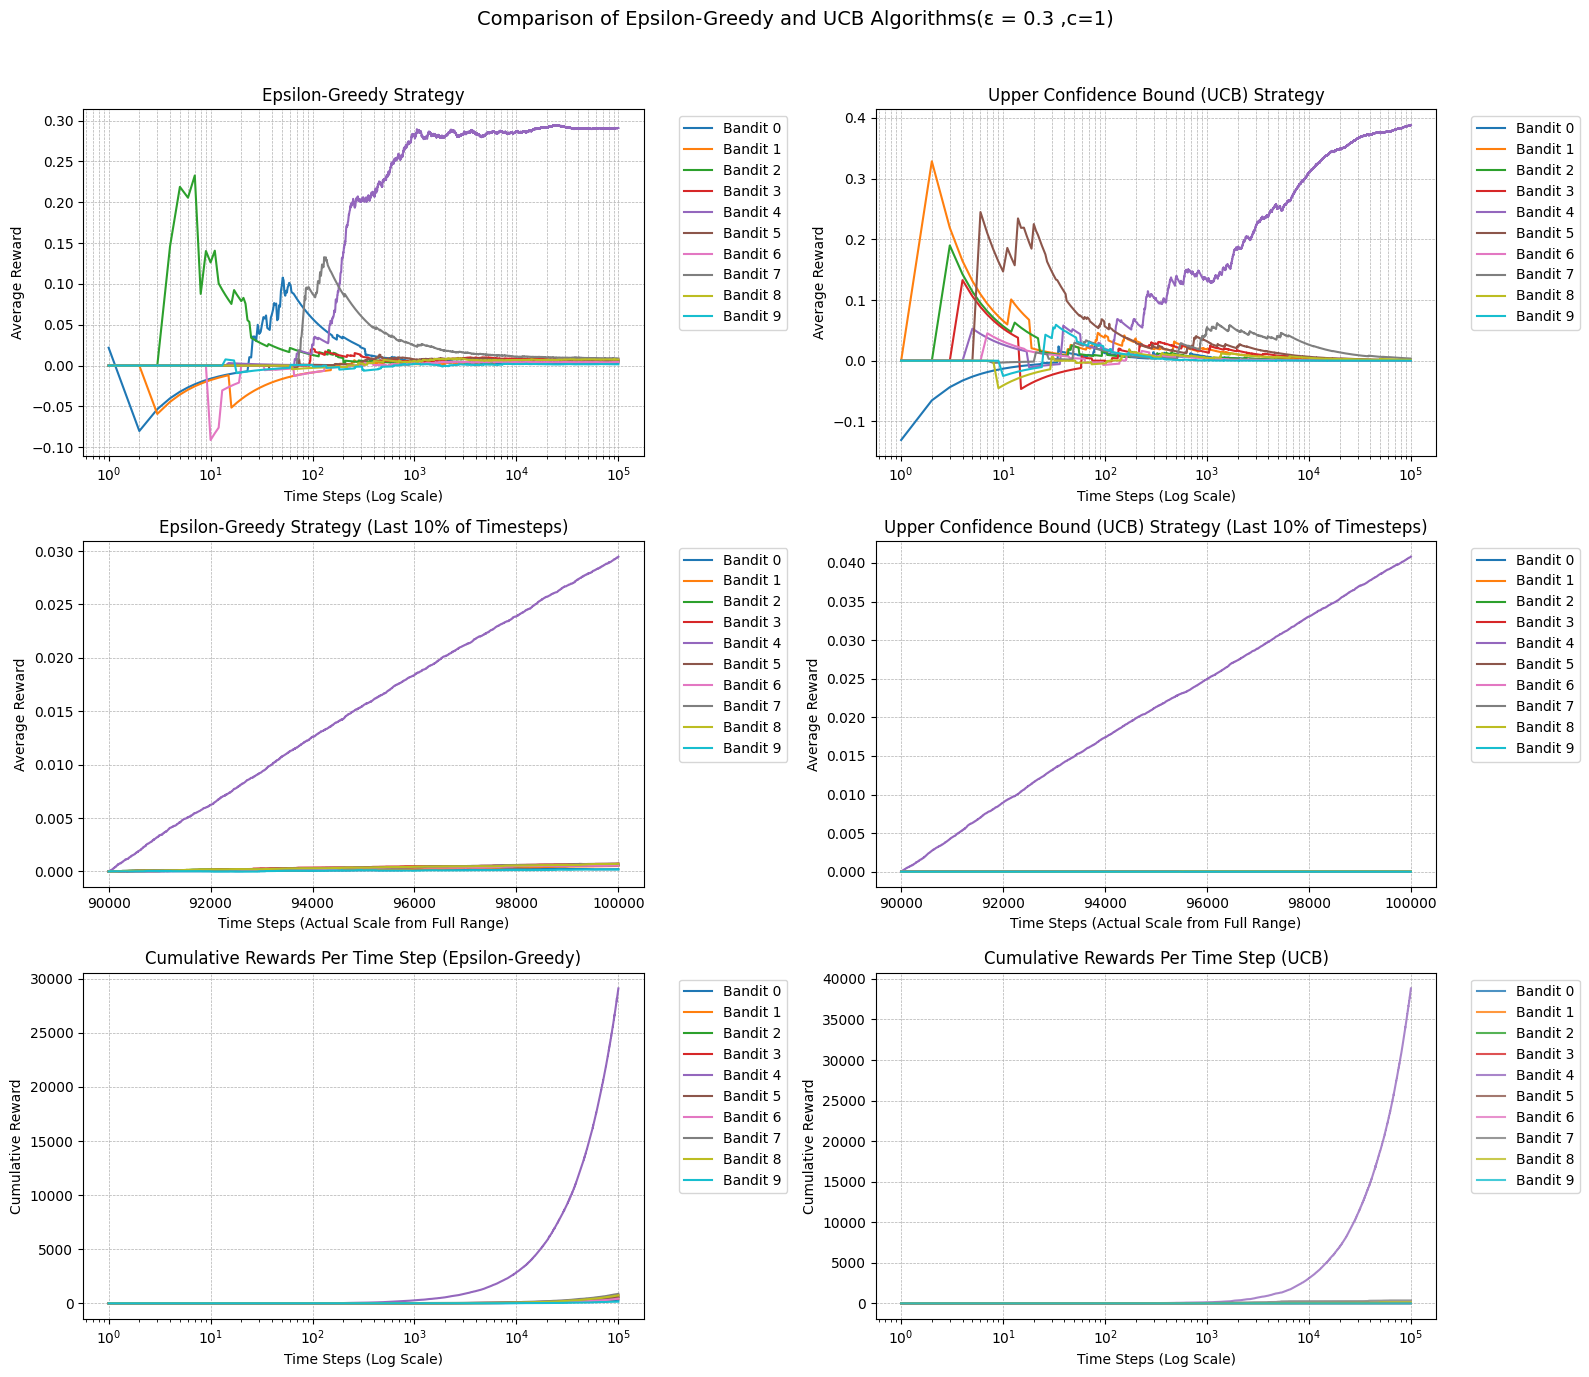

In [144]:
rew_epsilon_1, rew_ucb_1 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[1], ucb_c=c_values[1])

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 21966.82
- Best Bandit (UCB): Bandit 4 with Total Reward = 23224.68


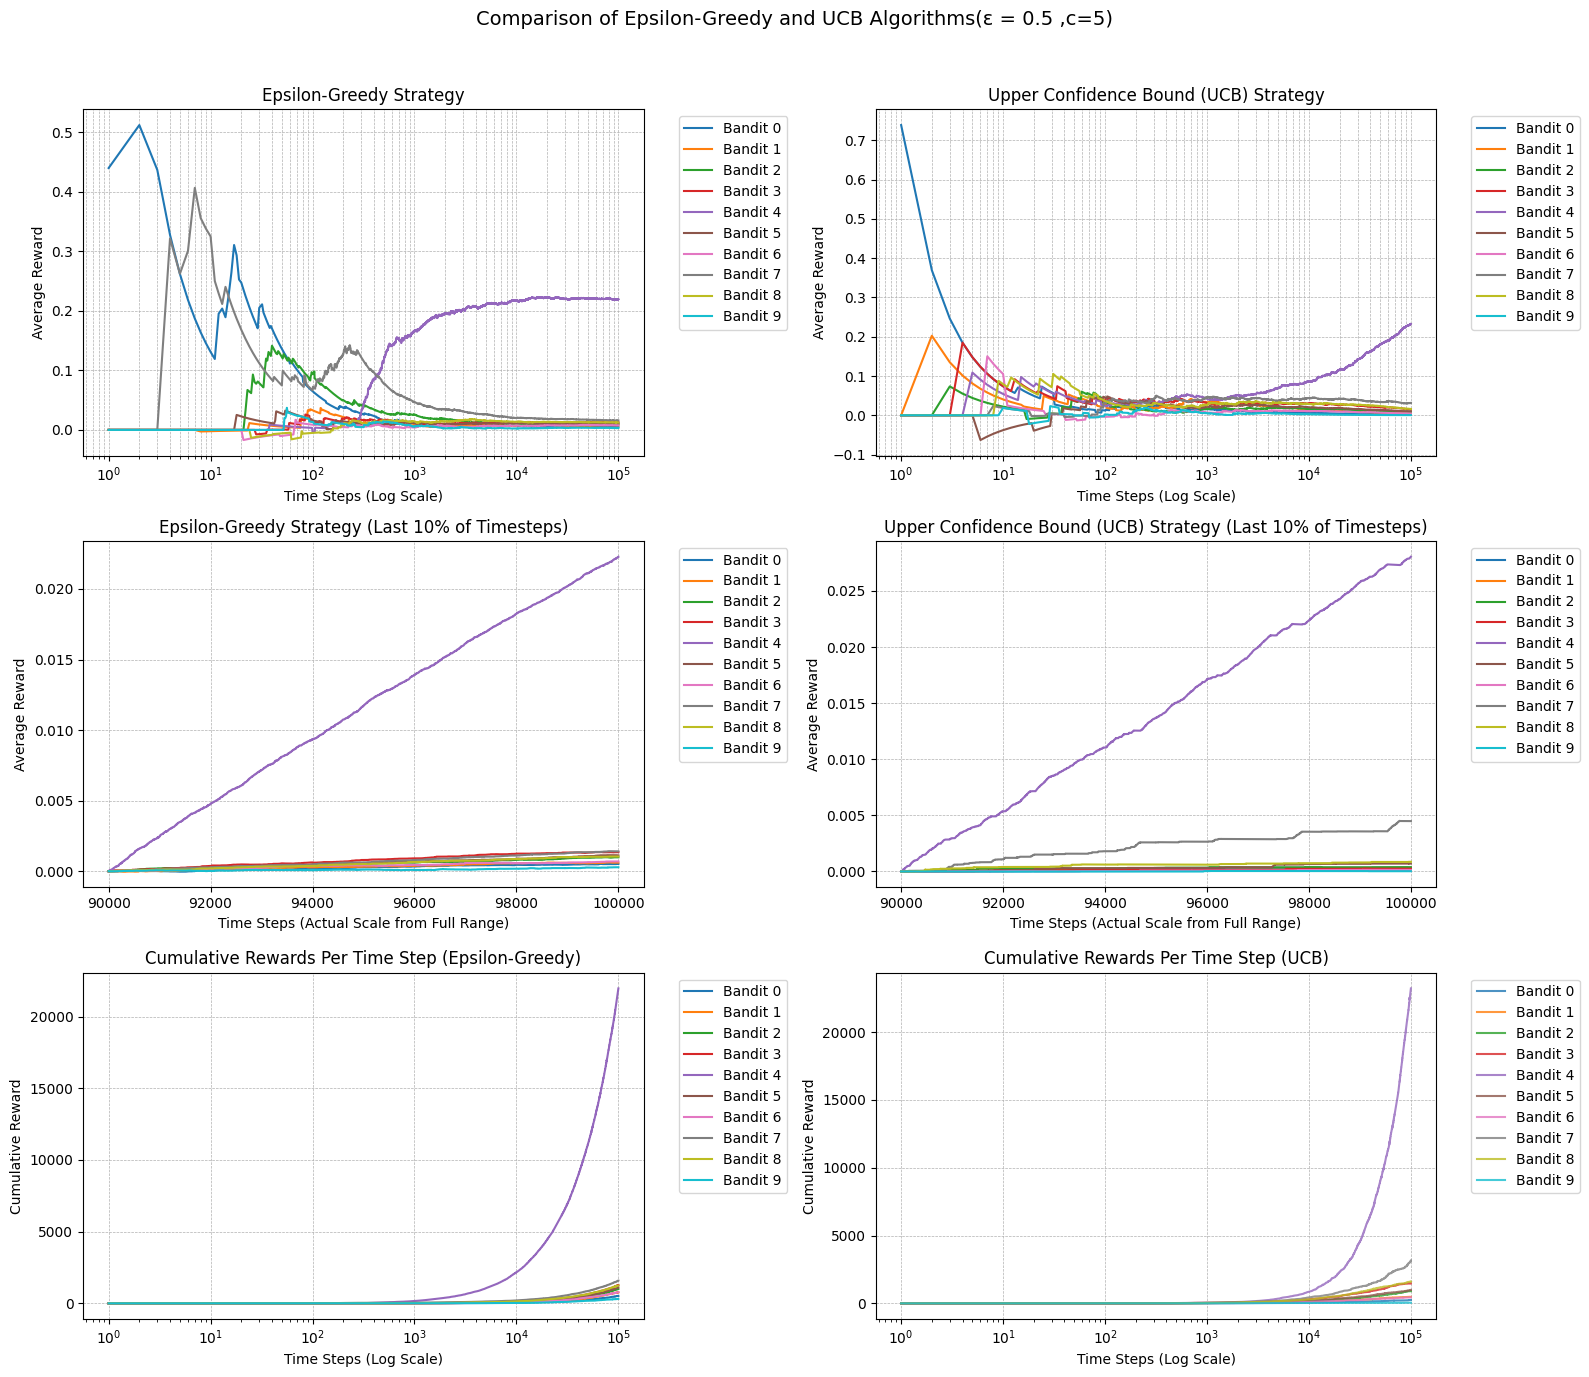

In [145]:
rew_epsilon_2, rew_ucb_2 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[2], ucb_c=c_values[2])

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 3956.42
- Best Bandit (UCB): Bandit 4 with Total Reward = 12274.70


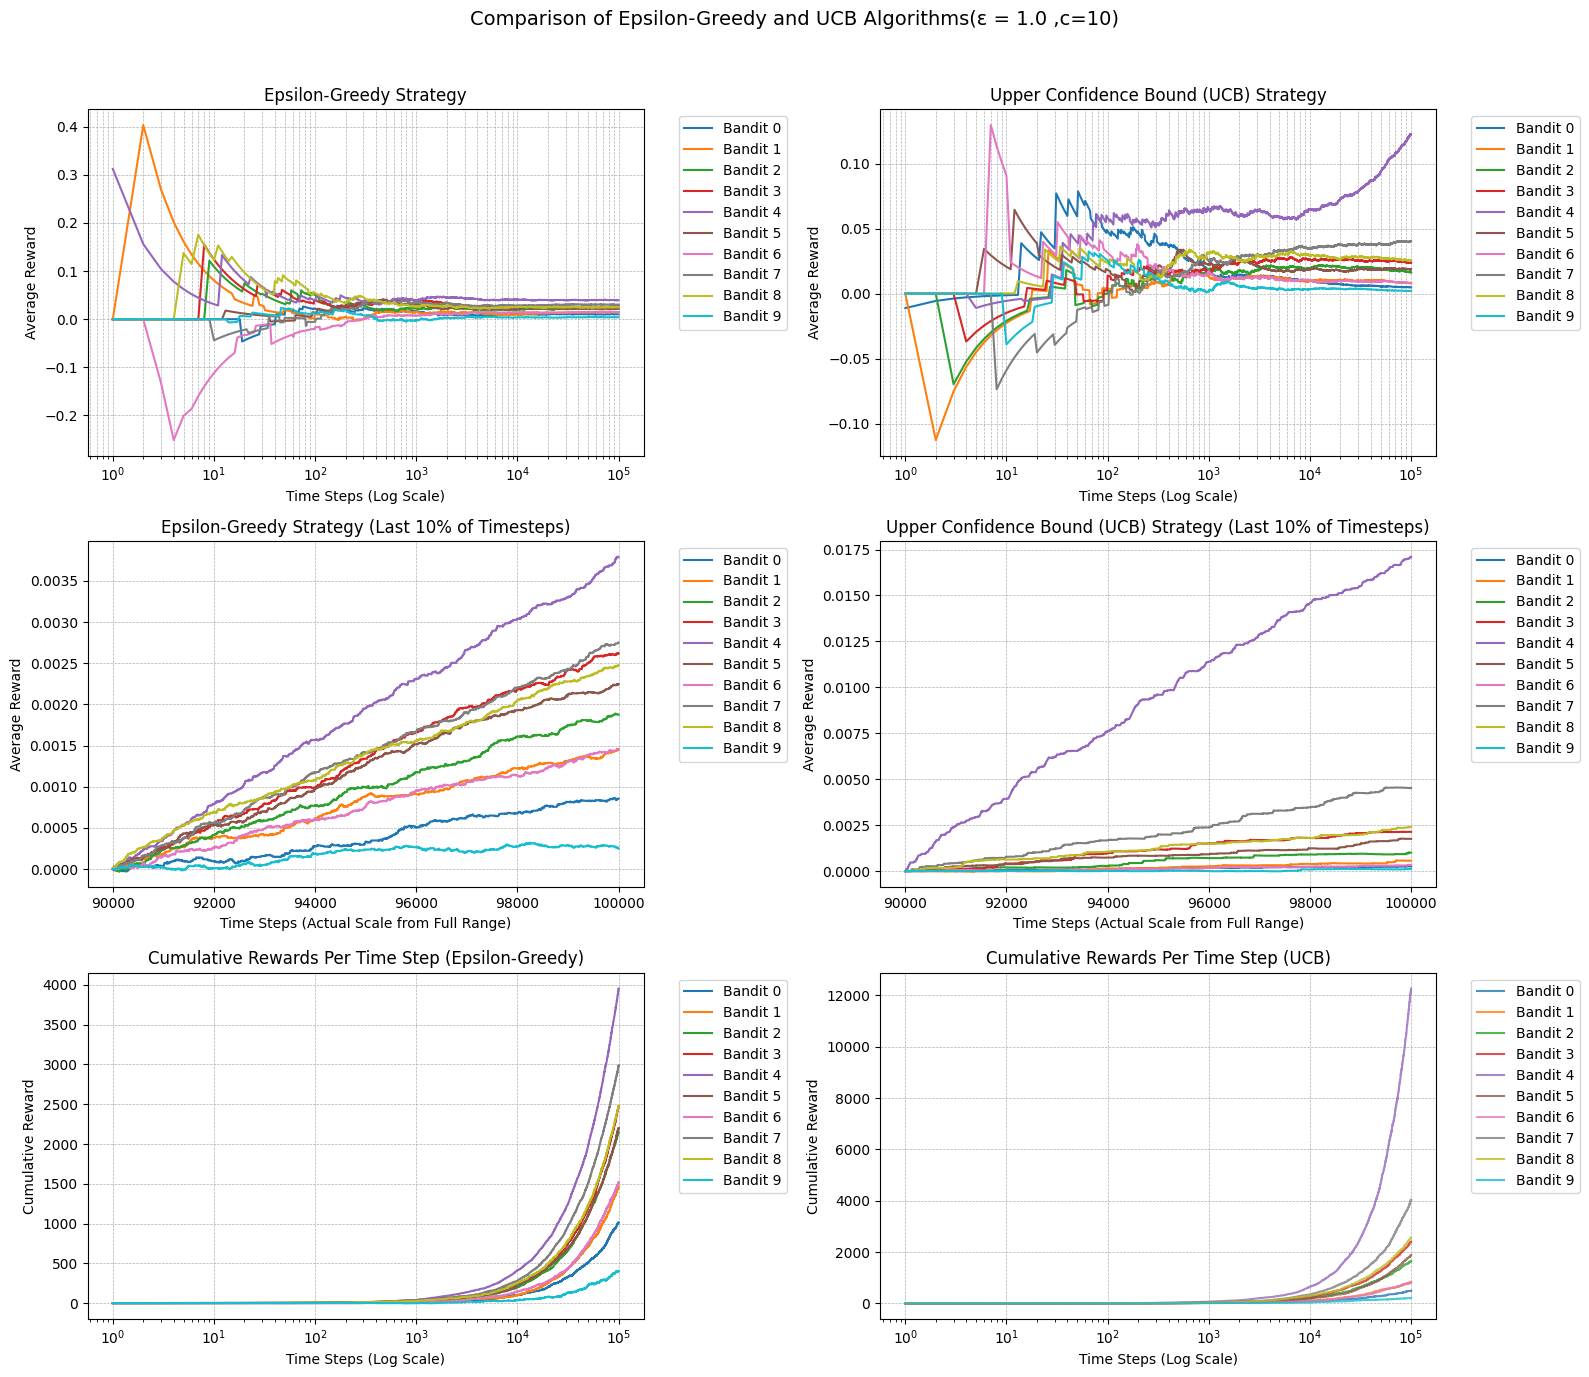

In [146]:
rew_epsilon_3, rew_ucb_3 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[3], ucb_c=c_values[3])

In [147]:
def extract_actions_from_rewards(reward_list, n_bandits):
    return [np.argmax(rewards, axis=0) for rewards in reward_list]

def plot_bandit_selection_counts(reward_epsilon_list, reward_ucb_list, epsilon_values, c_values, n_bandits):

    # Extract actions from rewards
    action_epsilon_list = extract_actions_from_rewards(reward_epsilon_list, n_bandits)
    action_ucb_list = extract_actions_from_rewards(reward_ucb_list, n_bandits)

    # Count selections per bandit
    total_selection_list = [np.bincount(actions, minlength=n_bandits) for actions in action_epsilon_list] + \
                           [np.bincount(actions, minlength=n_bandits) for actions in action_ucb_list]

    method_labels = [f"Epsilon {eps}" for eps in epsilon_values] + [f"UCB c {c}" for c in c_values]

    # Convert to NumPy array for plotting
    final_selections = np.array(total_selection_list)

    # Bar width calculation based on number of methods
    num_configs = len(total_selection_list)
    bar_width = 0.8 / num_configs  # Dynamically adjust width

    plt.figure(figsize=(15, 7))

    # X-axis positions (Bandit indices)
    x_positions = np.arange(n_bandits)  
    shift = (num_configs - 1) * bar_width / 2  # Centering shift

    # Plot each method's bandit selection counts as a bar
    for i in range(num_configs):
        if i < len(epsilon_values):
            color = plt.cm.Blues(i / len(epsilon_values))  # Shades of blue for epsilon methods
        else:
            color = plt.cm.Reds((i - len(epsilon_values)) / len(c_values))  # Shades of red for UCB

        plt.bar(x_positions - shift + i * bar_width, final_selections[i], width=bar_width, 
                label=method_labels[i], color=color, edgecolor="black")

    # Formatting
    plt.xlabel('Bandit Number', fontsize=14)
    plt.ylabel('Number of Times Selected', fontsize=14)
    plt.title('Bandit Selection Counts for Different Methods and Bandits', fontsize=16)

    # Adjust x-ticks to the middle of grouped bars
    plt.xticks(x_positions, [f'Bandit {b}' for b in x_positions])

    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
    plt.legend(title="Methods", fontsize=12)
    plt.tight_layout()

    plt.show()


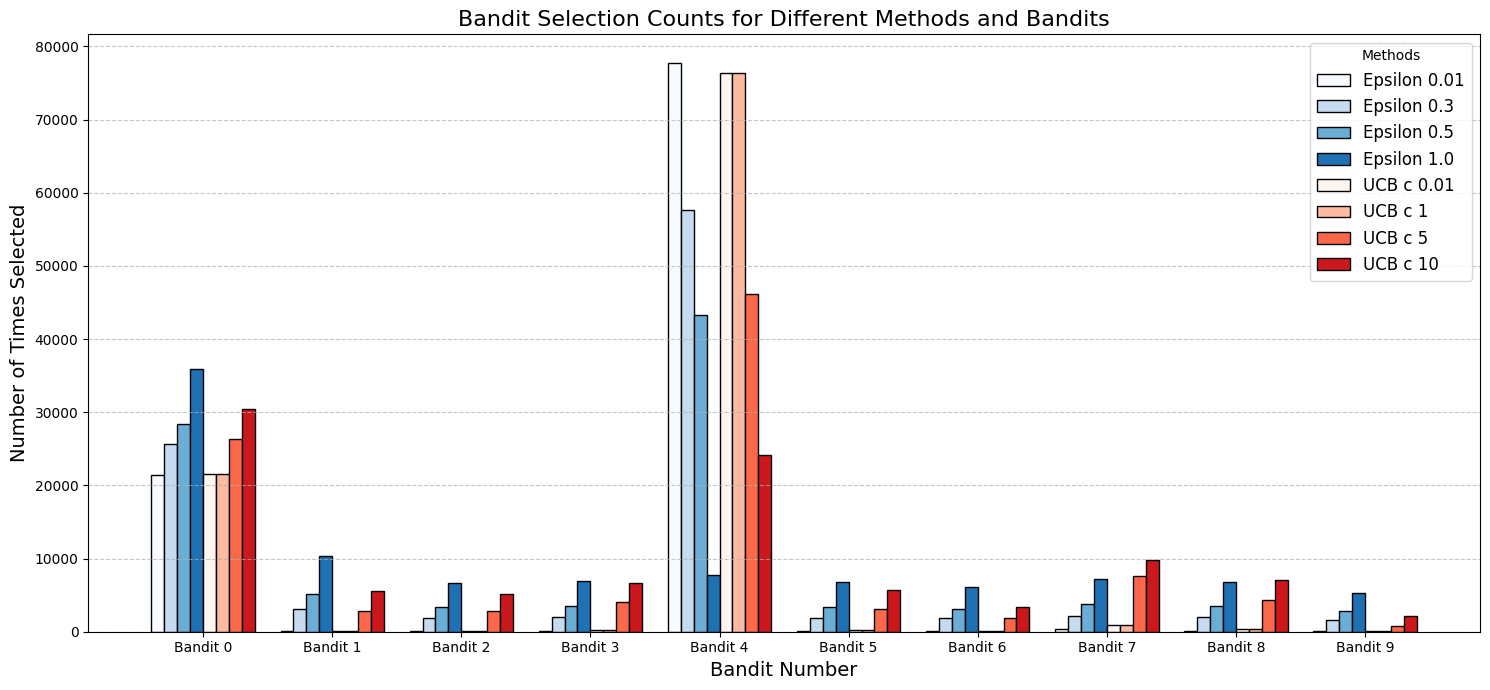

In [148]:
plot_bandit_selection_counts(
    reward_epsilon_list=[rew_epsilon_0, rew_epsilon_1, rew_epsilon_2, rew_epsilon_3],
    reward_ucb_list=[rew_ucb_1, rew_ucb_1, rew_ucb_2, rew_ucb_3],
    epsilon_values=epsilon_values,  # Example ε values
    c_values=c_values,  # Example UCB c values
    n_bandits=n_bandits
)


In [149]:
def plot_cumsum_per_config(rew_epsilon_list, rew_ucb_list, time_steps):    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  
    time_full = np.arange(time_steps) + 1  

    # --- Compute Cumulative Sum for Each Epsilon-Greedy Configuration ---
    for i, rewards in enumerate(rew_epsilon_list):
        actions = np.argmax(rewards, axis=0) 
        cumsum_action = np.cumsum(actions) / time_full 

        axes[0].plot(time_full, cumsum_action, label=f"Epsilon-Greedy Run {i+1}")

    axes[0].set_xscale("log") 
    axes[0].set_title("Cumulative Avg Selected Bandit Over Time (Epsilon-Greedy)")
    axes[0].set_xlabel("Time Steps (Log Scale)")
    axes[0].set_ylabel("Cumulative Avg Selected Bandit")
    axes[0].legend()
    axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

    # --- Compute Cumulative Sum for Each UCB Configuration ---
    for i, rewards in enumerate(rew_ucb_list):
        actions = np.argmax(rewards, axis=0)  
        cumsum_action = np.cumsum(actions) / time_full 

        axes[1].plot(time_full, cumsum_action, label=f"UCB Run {i+1}")

    axes[1].set_xscale("log")
    axes[1].set_title("Cumulative Avg Selected Bandit Over Time (UCB)")
    axes[1].set_xlabel("Time Steps (Log Scale)")
    axes[1].set_ylabel("Cumulative Avg Selected Bandit")
    axes[1].legend()
    axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.suptitle("Comparison of Cumulative Avg Selected Bandit Over Time (Epsilon-Greedy vs. UCB)")
    plt.tight_layout()
    plt.show()

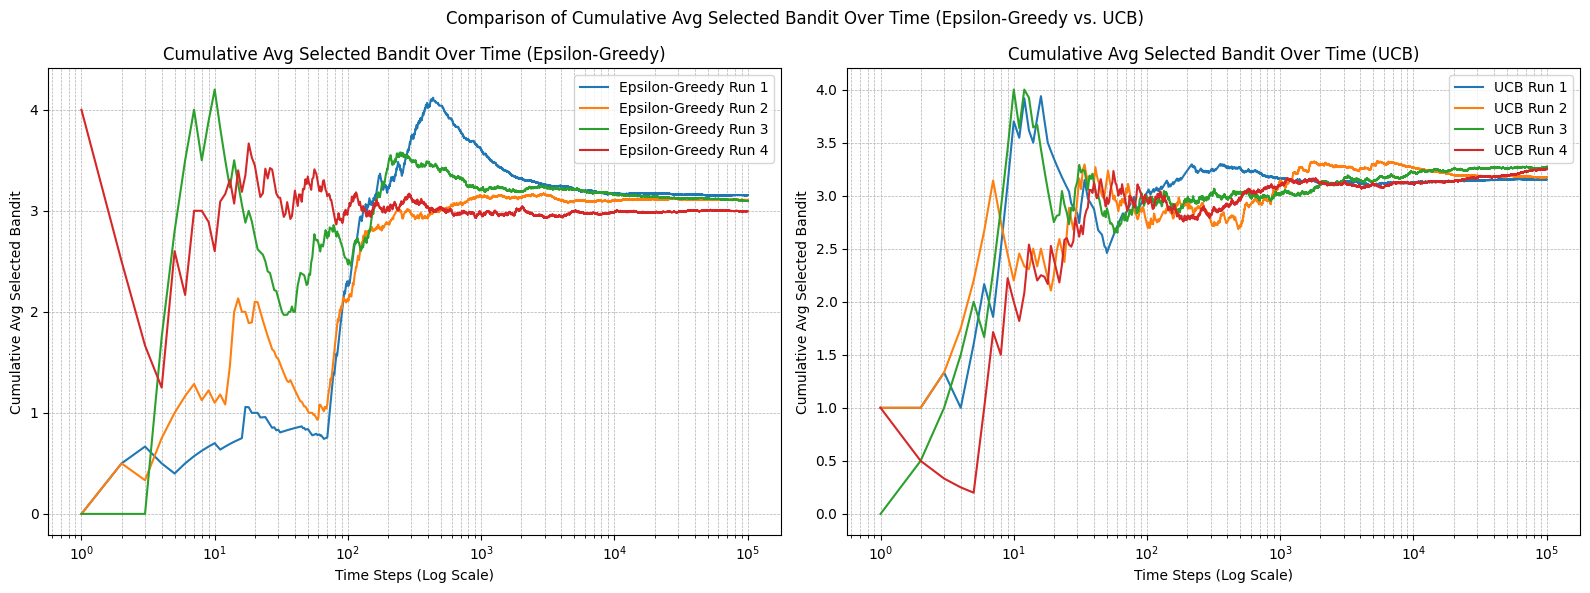

In [150]:
plot_cumsum_per_config(
    rew_epsilon_list=[rew_epsilon_0, rew_epsilon_1, rew_epsilon_2, rew_epsilon_3],  
    rew_ucb_list=[rew_ucb_0 ,rew_ucb_1, rew_ucb_2, rew_ucb_3],
    time_steps=time_step
    )